<a href="https://colab.research.google.com/github/prashanth-acsq/Colab-Notebooks/blob/main/stl/STL_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset = torchvision.datasets.STL10("/content/data", "unlabeled", download=True)

# train_X = np.fromfile("/content/data/stl10_binary/train_X.bin", dtype=np.uint8)
# train_X = train_X.reshape(-1, 96, 96, 3)
# train_X.shape [0.43141, 0.43113, 0.43062]

# test_X = np.fromfile("/content/data/stl10_binary/test_X.bin", dtype=np.uint8)
# test_X = test_X.reshape(-1, 96, 96, 3)
# test_X.shape

# un_X = np.fromfile("/content/data/stl10_binary/unlabeled_X.bin", dtype=np.uint8)
# un_X = un_X.reshape(-1, 96, 96, 3)
# un_X.shape [0.41824, 0.41800, 0.41745]

# tr = un_X[:80000]
# va = un_X[80000:]

# for tr_idx, va_idx in KFold(n_splits=5, shuffle=True, random_state=0).split(un_X): break

# tr = un_X[tr_idx]
# va = un_X[va_idx]

### **Library Imports**

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms, datasets

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### **Utilities and Constants**

In [2]:
SEED = 42
SIZE = 96

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()


def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(L)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()


def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

In [3]:
dataset = datasets.STL10("/content/data", "unlabeled", download=True)

train_X = np.fromfile("/content/data/stl10_binary/train_X.bin", dtype=np.uint8)
train_X = train_X.reshape(-1, 96, 96, 3)

test_X = np.fromfile("/content/data/stl10_binary/test_X.bin", dtype=np.uint8)
test_X = test_X.reshape(-1, 96, 96, 3)

train_y = np.fromfile("/content/data/stl10_binary/train_y.bin", dtype=np.uint8)
test_y  = np.fromfile("/content/data/stl10_binary/test_y.bin", dtype=np.uint8)

assert len(set(train_y)) == 10, "train_y loaded incorrectly"
assert len(set(test_y)) == 10, "test_y loaded incorrectly"

train_y -= 1
test_y -= 1

breaker()
for i in range(3):
    mean, std = 0.0, 0.0
    for j in range(len(train_X)):
        mean += train_X[j][:, :, i].mean()
        std += train_X[j][:, :, i].std()
    
    if i == 0:
        r_mean = mean / len(train_X) / 255
        r_std  = std / len(train_X) / 255
        print(f"Red Channel Mean   {SIZE} : {r_mean:.5f}")
        print(f"Red Channel Std    {SIZE} : {r_std:.5f}")

    if i == 1:
        g_mean = mean / len(train_X) / 255
        g_std  = std / len(train_X) / 255
        print(f"\nGreen Channel Mean {SIZE} : {g_mean:.5f}")
        print(f"Green Channel Std  {SIZE} : {g_std:.5f}")

    if i == 2:
        b_mean = mean / len(train_X) / 255
        b_std  = std / len(train_X) / 255
        print(f"\nBlue Channel Mean  {SIZE} : {b_mean:.5f}")
        print(f"Blue Channel Std   {SIZE} : {b_std:.5f}")
breaker()

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data

**************************************************

Red Channel Mean   96 : 0.43142
Red Channel Std    96 : 0.23119

Green Channel Mean 96 : 0.43113
Green Channel Std  96 : 0.23100

Blue Channel Mean  96 : 0.43062
Blue Channel Std   96 : 0.23087

**************************************************



### **No Unlabelled Data**

**Configuration**

In [17]:
class ClassifierCFG(object):
    def __init__(self, 
                 seed: int = 42,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 patience: int = 5,
                 eps: float = 1e-8,
                 freeze: bool = False,
                 train_transform=None,
                 ):
        
        self.seed = seed
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.patience = patience
        self.eps = eps

        self.train_base_path = ""
        self.test_base_path = ""
        
        self.freeze = freeze
        if not self.freeze:
            self.train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([r_mean, g_mean, b_mean], [r_std, g_std, b_std])])
        else:
            self.train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.test_transform = transforms.Compose([transforms.ToTensor(), ])
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)

    
cfg = ClassifierCFG(seed=SEED, size=SIZE)

**Dataset Template**

In [10]:
class ClassifierDS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray=None, transform=None):
        self.images = images
        self.labels = labels

        assert transform is not None, "transform cannot be None"

        self.transform = transform

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.transform(self.images[idx]), torch.LongTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

**Classifier Model**

In [11]:
class Classifier(nn.Module):
    def __init__(self, freeze: bool=False):
        super(Classifier, self).__init__()

        self.encoder = models.resnet50(pretrained=True, progress=True)
        if freeze: self.freeze()

        self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])
        self.AAP = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Linear(in_features=2048, out_features=10)
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded_aap = self.AAP(encoded)
        encoded_aap = encoded_aap.view(encoded_aap.shape[0], -1)
        classified = nn.LogSoftmax(dim=1)(self.classifier(encoded_aap))
        return encoded, encoded_aap, classified

In [12]:
# model = Classifier(True)

# for names, params in model.named_parameters():
#     if params.requires_grad:
#         print(names)

**Fit and Predict Helper**

In [13]:
def fit(model=None, 
        optimizer=None, 
        scheduler_oclr=None, 
        scheduler_rlrop=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None,
        device=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
    
    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, Accuracies, LRs = [], [], []
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    _, _, output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)

        if scheduler_oclr:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
                "scheduler_state_dict" : scheduler_oclr.state_dict(),
            }
        
        elif scheduler_rlrop:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
                "scheduler_state_dict" : scheduler_rlrop.state_dict(),
            }
        
        else:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
            }
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict, os.path.join(save_path, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
    
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
    
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
 Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                        epochLoss["train"], epochLoss["valid"], 
                                                                        epochAccs["train"], epochAccs["valid"], 
                                                                        time()-e_st))
        
    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name


def predict_batch(model=None, dataloader=None, device=None, path=None, mode="test") -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)
    model.eval()

    y_pred = torch.zeros(1, 1).to(device)

    if mode == "valid":
        for X, _ in dataloader:
            X = X.to(device)
            with torch.no_grad(): 
                _, _, output = model(X)
                output = torch.argmax(output, dim=1)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    else:
        for X in dataloader:
            X = X.to(device)
            with torch.no_grad():
                _, _, output = model(X)
                output = torch.argmax(output, dim=1)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

**Train and Test(Freeze=False)**

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.79507 | Valid Loss: 2.69433 | Train Accs: 0.36250 | Valid Accs: 0.20536 | Time: 40.80 seconds
Epoch: 2 | Train Loss: 1.37564 | Valid Loss: 2.62451 | Train Accs: 0.50750 | Valid Accs: 0.19147 | Time: 40.07 seconds
Epoch: 3 | Train Loss: 1.19535 | Valid Loss: 3.23825 | Train Accs: 0.57500 | Valid Accs: 0.12401 | Time: 39.54 seconds
Epoch: 4 | Train Loss: 1.04182 | Valid Loss: 2.41740 | Train Accs: 0.63250 | Valid Accs: 0.21825 | Time: 39.97 seconds
Epoch: 5 | Train Loss: 0.91348 | Valid Loss: 2.49631 | Train Accs: 0.68450 | Valid Accs: 0.20933 | Time: 39.12 seconds
Epoch: 6 | Train Loss: 0.76491 | Valid Loss: 2.70779 | Train Accs: 0.73100 | Valid Accs: 0.20734 | Time: 39.08 seconds
Epoch: 7 | Train Loss: 0.60555 | Valid Loss: 2.57154 | Train Accs: 0.79025 | Valid Accs: 0.25595 | Time: 39.09 seconds
Epoch: 8 | Train Loss: 0.54062 | Valid Loss: 3.0

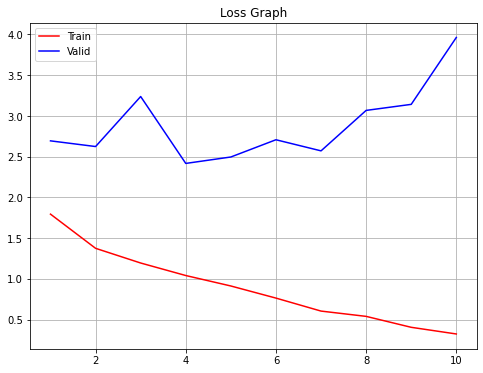

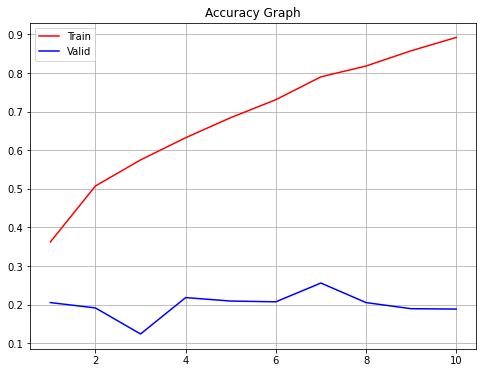

In [18]:
cfg = ClassifierCFG(freeze=False)

for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(train_X, train_y):
    break

tr_images, va_images, tr_labels, va_labels = train_X[tr_idx], train_X[va_idx], train_y[tr_idx], train_y[va_idx]

tr_data_setup = ClassifierDS(tr_images, tr_labels.reshape(-1, 1), cfg.train_transform)
va_data_setup = ClassifierDS(va_images, va_labels.reshape(-1, 1), cfg.test_transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg = ClassifierCFG(lr=1e-3, wd=0.0, epochs=25, batch_size=64, steps_per_epoch=len(dataloaders["train"]))

torch.manual_seed(cfg.seed)
model = Classifier(freeze=cfg.freeze).to(cfg.device)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)

# scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
#                                                max_lr=cfg.max_lr, 
#                                                epochs=cfg.epochs, 
#                                                steps_per_epoch=cfg.steps_per_epoch,
#                                                pct_start=cfg.pct_start, 
#                                                div_factor=cfg.div_factor, 
#                                                final_div_factor=cfg.final_div_factor)
# scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                        patience=cfg.patience,
#                                                        eps=cfg.eps,
#                                                        verbose=True)

scheduler_oclr = None
scheduler_rlrop = None

L, A, LR, BLE, BAE, name = fit(model=model, 
                                optimizer=optimizer, 
                                scheduler_oclr=scheduler_oclr,
                                scheduler_rlrop=scheduler_rlrop,
                                epochs=cfg.epochs, 
                                early_stopping_patience=cfg.early_stopping, 
                                dataloaders=dataloaders,  
                                save_path=cfg.save_path,
                                device=cfg.device,
                                verbose=True)

breaker()
show_loss_graphs(L)
show_accuracy_graphs(A)
if len(LR) > 0: show_lr_graph(LR)

In [19]:
ts_data_setup = ClassifierDS(test_X, None, cfg.test_transform)
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

y_pred = predict_batch(model=model, 
                       dataloader=ts_data, 
                       device=cfg.device, 
                       path=os.path.join(cfg.save_path, name), 
                       mode="test")

breaker()
print(f"Accuracy : {(accuracy_score(test_y, y_pred)):.5f}")
breaker()


**************************************************

Accuracy : 0.22200

**************************************************



**Train and Test (Freeze=True)**


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.90704 | Valid Loss: 4.02496 | Train Accs: 0.30630 | Valid Accs: 0.10430 | Time: 9.91 seconds
Epoch: 2 | Train Loss: 1.54639 | Valid Loss: 4.62712 | Train Accs: 0.44618 | Valid Accs: 0.11680 | Time: 9.60 seconds
Epoch: 3 | Train Loss: 1.44378 | Valid Loss: 3.60560 | Train Accs: 0.47545 | Valid Accs: 0.13164 | Time: 9.92 seconds
Epoch: 4 | Train Loss: 1.35975 | Valid Loss: 4.05356 | Train Accs: 0.50397 | Valid Accs: 0.14414 | Time: 9.56 seconds
Epoch: 5 | Train Loss: 1.36239 | Valid Loss: 3.94537 | Train Accs: 0.50595 | Valid Accs: 0.13320 | Time: 9.58 seconds
Epoch: 6 | Train Loss: 1.31843 | Valid Loss: 3.86569 | Train Accs: 0.52406 | Valid Accs: 0.13008 | Time: 9.59 seconds
Epoch: 7 | Train Loss: 1.25537 | Valid Loss: 4.45657 | Train Accs: 0.55382 | Valid Accs: 0.13184 | Time: 9.61 seconds
Epoch: 8 | Train Loss: 1.24121 | Valid Loss: 4.20735 | 

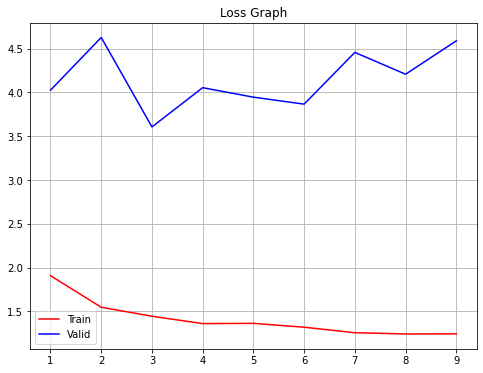

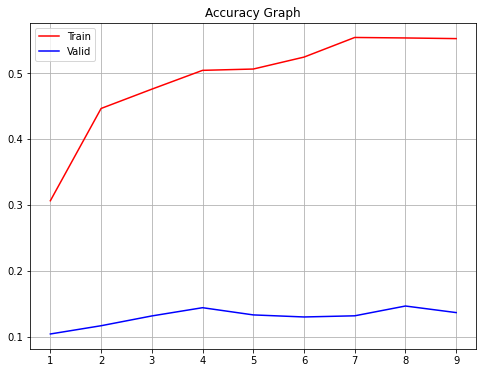

In [20]:
cfg = ClassifierCFG(freeze=True, lr=1e-3, wd=0.0, epochs=25, batch_size=64, steps_per_epoch=len(dataloaders["train"]))

for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(train_X, train_y):
    break

tr_images, va_images, tr_labels, va_labels = train_X[tr_idx], train_X[va_idx], train_y[tr_idx], train_y[va_idx]

tr_data_setup = ClassifierDS(tr_images, tr_labels.reshape(-1, 1), cfg.train_transform)
va_data_setup = ClassifierDS(va_images, va_labels.reshape(-1, 1), cfg.test_transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

torch.manual_seed(cfg.seed)
model = Classifier(freeze=cfg.freeze).to(cfg.device)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)

# scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
#                                                max_lr=cfg.max_lr, 
#                                                epochs=cfg.epochs, 
#                                                steps_per_epoch=cfg.steps_per_epoch,
#                                                pct_start=cfg.pct_start, 
#                                                div_factor=cfg.div_factor, 
#                                                final_div_factor=cfg.final_div_factor)
# scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                        patience=cfg.patience,
#                                                        eps=cfg.eps,
#                                                        verbose=True)

scheduler_oclr = None
scheduler_rlrop = None

L, A, LR, BLE, BAE, name = fit(model=model, 
                                optimizer=optimizer, 
                                scheduler_oclr=scheduler_oclr,
                                scheduler_rlrop=scheduler_rlrop,
                                epochs=cfg.epochs, 
                                early_stopping_patience=cfg.early_stopping, 
                                dataloaders=dataloaders,  
                                save_path=cfg.save_path,
                                device=cfg.device,
                                verbose=True)

breaker()
show_loss_graphs(L)
show_accuracy_graphs(A)
if len(LR) > 0: show_lr_graph(LR)

In [21]:
ts_data_setup = ClassifierDS(test_X, None, cfg.test_transform)
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

y_pred = predict_batch(model=model, 
                       dataloader=ts_data, 
                       device=cfg.device, 
                       path=os.path.join(cfg.save_path, name), 
                       mode="test")

breaker()
print(f"Accuracy : {(accuracy_score(test_y, y_pred)):.5f}")
breaker()


**************************************************

Accuracy : 0.13900

**************************************************



### **Using Unlabelled Data**